# Imports

In [2]:
import torch.nn as nn
import torchvision.transforms.functional as TF

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from skimage.util import invert
import skimage as ski
from skimage.filters import threshold_otsu

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [8]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
from PIL import Image

In [11]:
import os

In [56]:
from torchsummary import summary

# Model Architecture

In [12]:
class DoubleConv(nn.Module):
    def __init__ (self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)
        

In [70]:
class Unet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 2, features = [64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride = 2))
            self.ups.append(DoubleConv(feature*2, feature))
            
        
        self.bottom = DoubleConv(features[-1], features[-1]*2)
        self.last = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        sc = []

        for down in self.downs:
            x = down(x)
            sc.append(x)
            x = self.pool(x)

        x = self.bottom(x)
        sc = sc[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = sc[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.last(x)
            
        

### Model test

In [49]:
x = torch.rand((3,1,512,512))
model = Unet(in_channels=1, out_channels=1)
preds = model(x)
print(preds.shape)
print(x.shape)

torch.Size([3, 1, 512, 512])
torch.Size([3, 1, 512, 512])


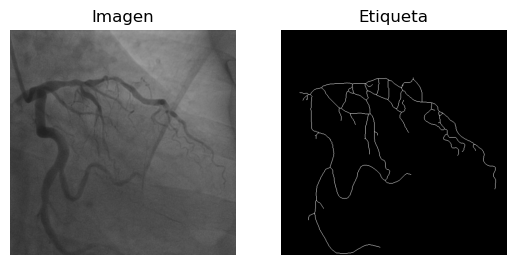

In [30]:
plt.subplot(1, 2, 1)
plt.title('Imagen')
plt.imshow(img1.squeeze().permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Etiqueta')
plt.imshow(label1.squeeze() , cmap="gray")  
plt.axis('off')

plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=len(X_test))

In [17]:
print(f"{len(X_train)} {len(X_test)} {len(X_val)}")

492 62 62


# Data processing

In [14]:
data_dir = './db'
# os.makedirs(os.path.join(data_dir, 'class1'), exist_ok=True)

## Skeletonization test

In [12]:
files = os.listdir(data_dir+'/unet_1/img')

In [24]:
files[0]

'nj_124_2_LCA_RAO.png'

In [10]:
def readImages(dir):
    img_file = os.listdir(data_dir+'/unet_1/img')
    label_file = os.listdir(data_dir+'/unet_1/label')
    list = [ [], [] ]
    for img, label in zip(img_file, label_file):
        list[0].append(ski.io.imread(dir+'/unet_1/img/'+img))
        list[1].append(ski.io.imread(dir+'/unet_1/label/'+label))
    return list[0], list[1]

In [11]:
img, label = readImages(data_dir)

In [12]:
gray_image = ski.color.rgb2gray(label[0])

In [13]:
gray_image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
gray_image.shape

(512, 512)

In [15]:
skeleton = skeletonize(gray_image)

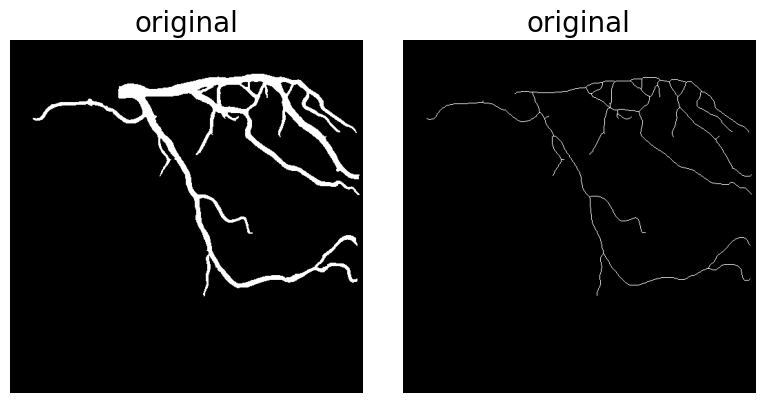

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(label[0], cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('original', fontsize=20)

fig.tight_layout()
plt.show()

## Label skeletonization

In [33]:
input_dir = os.path.join(data_dir, 'unet_1', 'label')
output_dir = os.path.join(data_dir, 'unet_1', 'label_skeleton')

In [18]:
labels = os.listdir(input_dir)

In [28]:
os.makedirs(output_dir, exist_ok=True)

In [30]:
for label in labels:
    input_image_path = os.path.join(input_dir, label)
    output_image_path = os.path.join(output_dir, label)
    image = ski.io.imread(input_image_path)

    if image.dtype == 'bool':
        image = img_as_ubyte(image)
        
    if image.ndim == 3 and image.shape[2] == 3:
        image = ski.color.rgb2gray(image)

    image = skeletonize(image)

    image = ski.img_as_ubyte(image)

    ski.io.imsave(output_image_path, image)

/var/folders/j2/4gt7_tx57772t1zrdf4g5gm40000gn/T/ipykernel_24057/3240581223.py:13: UserWarning: ./db/unet_1/label_skeleton/nj_20_LCA_LAO.png is a low contrast image
  ski.io.imsave(output_image_path, image)
/var/folders/j2/4gt7_tx57772t1zrdf4g5gm40000gn/T/ipykernel_24057/3240581223.py:13: UserWarning: ./db/unet_1/label_skeleton/nj_71_RCA_RAO.png is a low contrast image
  ski.io.imsave(output_image_path, image)
/var/folders/j2/4gt7_tx57772t1zrdf4g5gm40000gn/T/ipykernel_24057/3240581223.py:13: UserWarning: ./db/unet_1/label_skeleton/nj_25_RCA_LAO.png is a low contrast image
  ski.io.imsave(output_image_path, image)
/var/folders/j2/4gt7_tx57772t1zrdf4g5gm40000gn/T/ipykernel_24057/3240581223.py:13: UserWarning: ./db/unet_1/label_skeleton/nj_1_RCA_LAO.png is a low contrast image
  ski.io.imsave(output_image_path, image)
/var/folders/j2/4gt7_tx57772t1zrdf4g5gm40000gn/T/ipykernel_24057/3240581223.py:13: UserWarning: ./db/unet_1/label_skeleton/nj_55_RCA_LAO.png is a low contrast image
  ski.io

In [37]:
total = len(labels)
final = len(os.listdir(output_dir))
print(100 * (final/total))
print(final)
print(total)

85.55194805194806
527
616


# Data loading

## Dataset class

In [34]:
class UnetDataset(Dataset):
    
    def __init__(self, img_dir, label_dir, names , transform=None):
        super().__init__()
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.names = names
        self.transform = transform
        
    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.names[idx])
        label_path = os.path.join(self.label_dir, self.names[idx])
        image = np.array(Image.open(img_path).convert("RGB"))
        label = np.array(Image.open(label_path).convert("L"), dtype=np.float32)
        label[label == 255.0] = 1.0
        
        
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        
        return image, label

## Data split

In [71]:
names = os.listdir(data_dir+'/unet_1/label_skeleton')

In [72]:
img_dir = "./db/unet_1/img"
label_dir = "./db/unet_1/label_skeleton"

In [73]:
train_dataset = UnetDataset(img_dir, label_dir, names, transform = ToTensor())
test_dataset = UnetDataset(img_dir, label_dir, names, transform = ToTensor())
val_dataset = UnetDataset(img_dir, label_dir, names, transform = ToTensor())

In [74]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [75]:
img1, label1 = train_dataset[0]

In [76]:
img1

tensor([[[0.2745, 0.3020, 0.3216,  ..., 0.5294, 0.4824, 0.4510],
         [0.2902, 0.3098, 0.3333,  ..., 0.5647, 0.5333, 0.5098],
         [0.2980, 0.3255, 0.3451,  ..., 0.5804, 0.5529, 0.5412],
         ...,
         [0.1647, 0.1686, 0.1686,  ..., 0.2275, 0.2275, 0.2392],
         [0.1608, 0.1686, 0.1647,  ..., 0.2314, 0.2196, 0.2314],
         [0.1569, 0.1725, 0.1608,  ..., 0.2275, 0.2157, 0.2196]],

        [[0.2745, 0.3020, 0.3216,  ..., 0.5294, 0.4824, 0.4510],
         [0.2902, 0.3098, 0.3333,  ..., 0.5647, 0.5333, 0.5098],
         [0.2980, 0.3255, 0.3451,  ..., 0.5804, 0.5529, 0.5412],
         ...,
         [0.1647, 0.1686, 0.1686,  ..., 0.2275, 0.2275, 0.2392],
         [0.1608, 0.1686, 0.1647,  ..., 0.2314, 0.2196, 0.2314],
         [0.1569, 0.1725, 0.1608,  ..., 0.2275, 0.2157, 0.2196]],

        [[0.2745, 0.3020, 0.3216,  ..., 0.5294, 0.4824, 0.4510],
         [0.2902, 0.3098, 0.3333,  ..., 0.5647, 0.5333, 0.5098],
         [0.2980, 0.3255, 0.3451,  ..., 0.5804, 0.5529, 0.

In [77]:
img1.shape

torch.Size([3, 512, 512])

In [78]:
label1

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [79]:
label1.shape

torch.Size([1, 512, 512])

# Model Training

- Accuracy
- F1 score
- Coeficinete dice
- Recall
- Especificidad
- Presición

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [80]:
model = Unet(in_channels=3, out_channels=1).to(device)

In [81]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [82]:
epochs = 5
train_losses = []
test_losses = []
val_losses = []

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.float().to(device)
        y_train = y_train.float().to(device)
        
        # Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    t_len = len(train_loader)
    train_losses.append(train_loss / t_len)
    
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):

            X_val = X_val.float().to(device)
            y_val = y_val.float().to(device)
            
            # Forward pass
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            val_loss += loss.item()
    
    v_len = len(val_loader)
    val_losses.append(val_loss / v_len)

    print(f"Epoch {epoch+1} "
          f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, ")

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8


In [ ]:
model.eval()
with torch.no_grad():
    test_loss = 0
    f1_test = 0
    recall_test = 0
    acc_test = 0
    precision_test = 0
    
    for b, (X_test, y_test) in enumerate(test_loader):
        X_test, y_test = X_test.to(device), y_test.to(device)
        
        y_pred = model(X_test)
        loss = criterion(y_pred, y_test)
        test_loss += loss.item()
        
        y_pred_np = torch.argmax(y_pred, dim=1).cpu().numpy()
        y_test_np = y_test.cpu().numpy()

    t_len = len(test_loader)
    test_loss /= t_len

    
    print(f"Test Loss: {test_loss:.4f}")

# Evaluation

### Train

In [ ]:
plt.figure()
plt.plot(np.array(train_losses))
plt.title('Perdida en entrenamiento')
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

### Validation

In [ ]:
plt.figure()
plt.plot(np.array(val_losses))
plt.title('Perdida en validacion')
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.show()

### Test

In [ ]:
plt.figure()
plt.plot(np.array(test_losses))
plt.title('Perdida en pruebas')
plt.xlabel('sample')
plt.ylabel('test loss')
plt.show()

## Loss Function

- Binary cross entropy loss function

In [63]:
def ce(y, y_i):
    ep = 1e-8
    part1 = y_i * np.log(y+ep)
    part2 = (1 - y_i)*np.log(1-y+ep)
    return np.mean(-(part1+part2))

In [64]:
y = np.linspace(0,1, 10)
y_i = np.zeros(10)
y_i2 = np.ones(10)

r1 = ce(y, y_i)
r2 = ce(y, y_i2)

In [68]:
x = np.linspace(0,1,9).reshape(3,3)

In [69]:
x

array([[0.   , 0.125, 0.25 ],
       [0.375, 0.5  , 0.625],
       [0.75 , 0.875, 1.   ]])

In [72]:
y_1 = np.ones(9).reshape(3,3)

In [73]:
y_0 = np.zeros(9).reshape(3,3)

In [74]:
ce(x, y_1)

2.7168455508019154

In [65]:
r1

2.5393874205289735

In [66]:
r2

2.539387420528974

In [52]:
r1

array([       nan, 0.11778304, 0.25131443, 0.40546511, 0.58778666,
       0.81093022, 1.09861229, 1.5040774 , 2.19722458,        inf])

In [53]:
r2

array([       inf, 2.19722458, 1.5040774 , 1.09861229, 0.81093022,
       0.58778666, 0.40546511, 0.25131443, 0.11778304,        nan])

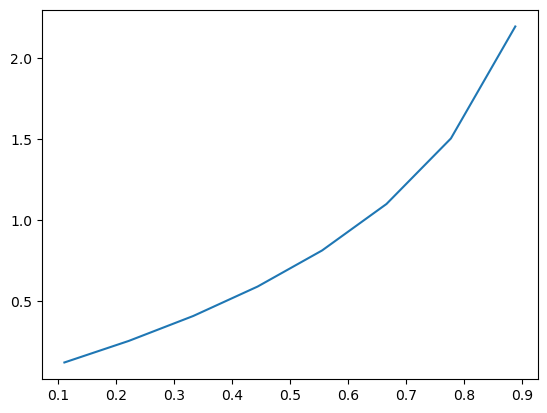

In [54]:
plt.plot(y, r1)

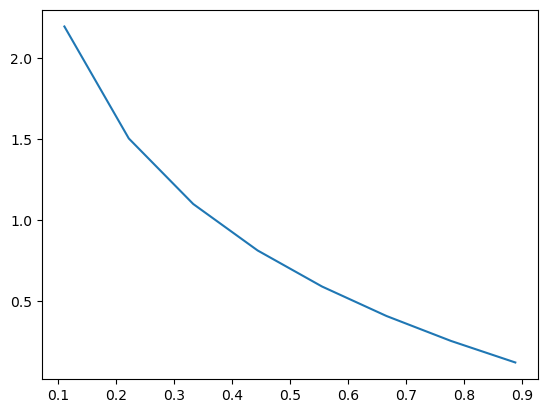

In [55]:
plt.plot(y, r2)

In [ ]:
loss = nn.BCELoss()